In [ ]:
Name  :Yoneshwar Babu 
ASU ID:1220454365

![](DOPR1P1.png)


In [45]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [46]:
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 10.0  # m/s2, gravity constant
BOOST_ACCEL = 15.0  # m/s2, thrust constant
FUEL_CONSUMPTION = 1 # We assume it is directly proportional to the acceleration

In [47]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        

        states:
        state[0] = x
        state[1] = v_x
        state[2] = y
        state[3] = v_y
        state[4] = fuel_consumption
        """

        # Apply gravity
        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME, 0.])

        # Thrust of x and y directions are calculated respectively
        thrust_x = action[0] * 2.0 - 1.0
        thrust_y = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0, 0., 0. , 0.]) * thrust_x
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.0, 0.]) * thrust_y

        # We assume that the rocket has some fixed amount of fuel and will be depleted based proportional to the acceleration
        # The added constraint is that there is only a fixed amount of fuel, and therefore any deviation from that value would
# be considered as a loss. The goal is to consume fuel, but prioritize other parameters first. Therefore, the weightage to the fuel
# would be kept low.


        delta_state_fuel_boost = t.tensor([0., 0., 0., 0., 2*thrust_y])
        delta_state_fuel = delta_state_fuel_boost

        # Update velocity, both gravity, thrust of x and y are used
        state = state + delta_state_x + delta_state_y + delta_state_gravity + delta_state_fuel + delta_state_fuel
       
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.] ])
        state = t.matmul(step_mat, state)

        return state



In [48]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),  #
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0, 0]
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        # We assume that 300 is the fuel capacity
        # If consumed fuel is less than 300, then the error is 0
        if(state[4]<300):
            fuel_error=0
        else:
            fuel_error=100
        # Optionally monitor state here
        print("For state ",state,fuel_error)
        return state[0] ** 2 + state[1] ** 2 + state[2] ** 2 + state[3] ** 2 + fuel_error

In [64]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 10 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        v_x = data[:, 1]
        y1 = data[:, 2]
        v_y = data[:, 3]
        fuel = data[:, 4]
        tt = range(self.simulation.T)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_xx = data1[:, 0]
        thrust_yy = data1[:, 1]
        
            

        plt.plot(tt, fuel, c='g', label='fuel')
        #ax[3].plot(tt, thrust_yy, c='r', label='y thrust')
        plt.set_xlabel('time')
        plt.set_ylabel('fuel consumption')
        plt.set(title='Fuel plot')
        plt.legend()

        plt.show()   


For state  tensor([ -78.3034,  -11.3120, -126.7869,  -32.5035,  177.3241],
       grad_fn=<MvBackward>) 0
For state  tensor([ -77.5438,  -11.1240, -126.5874,  -32.4581,  177.4452],
       grad_fn=<MvBackward>) 0
For state  tensor([ -76.5255,  -10.8692, -126.2156,  -32.3784,  177.6577],
       grad_fn=<MvBackward>) 0
For state  tensor([ -75.1890,  -10.5319, -125.6307,  -32.2559,  177.9842],
       grad_fn=<MvBackward>) 0
For state  tensor([ -73.3969,  -10.0771, -124.7656,  -32.0765,  178.4629],
       grad_fn=<MvBackward>) 0
For state  tensor([ -70.7682,   -9.4086, -123.4304,  -31.8003,  179.1992],
       grad_fn=<MvBackward>) 0
For state  tensor([ -66.8733,   -8.4206, -121.3905,  -31.3797,  180.3207],
       grad_fn=<MvBackward>) 0
For state  tensor([ -61.6768,   -7.1107, -118.6000,  -30.8072,  181.8474],
       grad_fn=<MvBackward>) 0
For state  tensor([ -54.4743,   -5.3079, -114.6610,  -30.0014,  183.9962],
       grad_fn=<MvBackward>) 0
For state  tensor([ -34.3941,   -0.7712, -103.

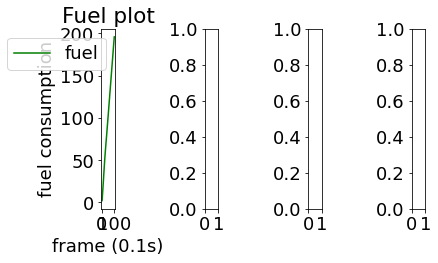

For state  tensor([-16.7073,   2.1544, -92.5916, -25.6147, 195.6943],
       grad_fn=<MvBackward>) 0
For state  tensor([-15.8508,   2.2820, -91.7570, -25.4694, 196.0813],
       grad_fn=<MvBackward>) 0
For state  tensor([-15.0455,   2.4007, -90.9210, -25.3238, 196.4696],
       grad_fn=<MvBackward>) 0
For state  tensor([-14.2865,   2.5113, -90.0811, -25.1776, 196.8597],
       grad_fn=<MvBackward>) 0
For state  tensor([-13.5705,   2.6145, -89.2354, -25.0302, 197.2530],
       grad_fn=<MvBackward>) 0
For state  tensor([-12.8944,   2.7109, -88.3825, -24.8815, 197.6493],
       grad_fn=<MvBackward>) 0
For state  tensor([-12.2560,   2.8008, -87.5215, -24.7313, 198.0499],
       grad_fn=<MvBackward>) 0
For state  tensor([-11.6535,   2.8847, -86.6523, -24.5795, 198.4543],
       grad_fn=<MvBackward>) 0
For state  tensor([-11.0852,   2.9628, -85.7742, -24.4260, 198.8637],
       grad_fn=<MvBackward>) 0
For state  tensor([-10.5499,   3.0355, -84.8875, -24.2709, 199.2777],
       grad_fn=<MvBac

For state  tensor([  5.7891,   3.7909, -16.0131, -12.8350, 229.7733],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.8302,   3.7847, -15.5504, -12.7474, 230.0068],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.8653,   3.7784, -15.1096, -12.6634, 230.2309],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.8949,   3.7718, -14.6893, -12.5827, 230.4461],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9191,   3.7651, -14.2888, -12.5053, 230.6525],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9385,   3.7583, -13.9071, -12.4310, 230.8507],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9534,   3.7512, -13.5427, -12.3596, 231.0411],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9645,   3.7441, -13.1946, -12.2909, 231.2241],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9726,   3.7368, -12.8612, -12.2248, 231.4005],
       grad_fn=<MvBackward>) 0
For state  tensor([  5.9778,   3.7293, -12.5412, -12.1610, 231.5708],
       grad_fn=<MvBac

For state  tensor([  3.8244,   3.1224,  -3.0898, -10.0766, 237.1293],
       grad_fn=<MvBackward>) 0
[9] loss: 135.459
For state  tensor([  3.8244,   3.1224,  -3.0898, -10.0766, 237.1293],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.7888,   3.1161,  -3.0238, -10.0585, 237.1773],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.7535,   3.1098,  -2.9587, -10.0406, 237.2250],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.7184,   3.1036,  -2.8945, -10.0229, 237.2723],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.6834,   3.0974,  -2.8311, -10.0052, 237.3194],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.6486,   3.0913,  -2.7687,  -9.9877, 237.3662],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.6141,   3.0853,  -2.7070,  -9.9703, 237.4125],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.5796,   3.0793,  -2.6462,  -9.9531, 237.4583],
       grad_fn=<MvBackward>) 0
For state  tensor([  3.5455,   3.0735,  -2.5861,  -9.9360, 237.5041],
   

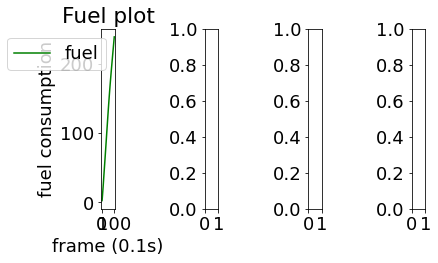

For state  tensor([  2.5458,   2.9120,  -0.9465,  -9.4201, 238.8797],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.5125,   2.9068,  -0.9044,  -9.4050, 238.9201],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.4880,   2.9034,  -0.8503,  -9.3862, 238.9701],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.4550,   2.8984,  -0.8084,  -9.3709, 239.0107],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.4294,   2.8949,  -0.7553,  -9.3522, 239.0608],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.3972,   2.8900,  -0.7127,  -9.3364, 239.1029],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.3702,   2.8863,  -0.6612,  -9.3178, 239.1526],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.3384,   2.8816,  -0.6175,  -9.3013, 239.1964],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.3102,   2.8777,  -0.5669,  -9.2826, 239.2465],
       grad_fn=<MvBackward>) 0
For state  tensor([  2.2786,   2.8731,  -0.5220,  -9.2654, 239.2924],
       grad_fn=<MvBac

For state  tensor([ -1.1032,   2.5671,   1.8637,  -5.6970, 248.8080],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0993,   2.5677,   1.8575,  -5.6863, 248.8364],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0954,   2.5684,   1.8513,  -5.6758, 248.8644],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0915,   2.5690,   1.8449,  -5.6654, 248.8922],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0874,   2.5697,   1.8385,  -5.6551, 248.9198],
       grad_fn=<MvBackward>) 0
[15] loss: 43.146
For state  tensor([ -1.0874,   2.5697,   1.8385,  -5.6551, 248.9198],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0834,   2.5703,   1.8321,  -5.6449, 248.9470],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0794,   2.5710,   1.8255,  -5.6348, 248.9740],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0752,   2.5716,   1.8189,  -5.6247, 249.0009],
       grad_fn=<MvBackward>) 0
For state  tensor([ -1.0711,   2.5723,   1.8123,  -5.6147, 249.0273],
   

For state  tensor([ 6.5709e-02,  2.9509e+00,  1.0557e+00, -3.7849e+00,  2.5391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 5.8757e-02,  2.9461e+00,  1.0503e+00, -3.7731e+00,  2.5394e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 5.1635e-02,  2.9405e+00,  1.0449e+00, -3.7615e+00,  2.5397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.4514e-02,  2.9344e+00,  1.0395e+00, -3.7499e+00,  2.5400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.7295e-02,  2.9277e+00,  1.0343e+00, -3.7385e+00,  2.5403e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.9917e-02,  2.9204e+00,  1.0290e+00, -3.7273e+00,  2.5406e+02],
       grad_fn=<MvBackward>) 0
[19] loss: 23.482
For state  tensor([ 2.9917e-02,  2.9204e+00,  1.0290e+00, -3.7273e+00,  2.5406e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2569e-02,  2.9127e+00,  1.0238e+00, -3.7162e+00,  2.5409e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.5167e-02,  2.9044e+00,  1.0187e+

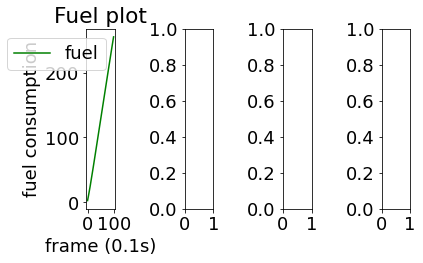

For state  tensor([-2.3540e-01,  2.2962e+00,  8.4688e-01, -3.3413e+00,  2.5509e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.4007e-01,  2.2717e+00,  8.4220e-01, -3.3301e+00,  2.5512e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.4434e-01,  2.2474e+00,  8.3752e-01, -3.3190e+00,  2.5515e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.4814e-01,  2.2239e+00,  8.3296e-01, -3.3082e+00,  2.5518e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5136e-01,  2.2017e+00,  8.2854e-01, -3.2980e+00,  2.5521e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5411e-01,  2.1811e+00,  8.2435e-01, -3.2885e+00,  2.5523e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ -0.2562,   2.1624,   0.8202,  -3.2798, 255.2539],
       grad_fn=<MvBackward>) 0
For state  tensor([ -0.2581,   2.1454,   0.8166,  -3.2717, 255.2753],
       grad_fn=<MvBackward>) 0
For state  tensor([ -0.2592,   2.1302,   0.8125,  -3.2645, 255.2948],
       grad_fn=<MvBackward>) 0
F

For state  tensor([-2.0348e-01,  8.7455e-01,  3.7922e-01, -2.1256e+00,  2.5833e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.9975e-01,  8.6201e-01,  3.7515e-01, -2.1062e+00,  2.5838e+02],
       grad_fn=<MvBackward>) 0
[25] loss: 5.360
For state  tensor([-1.9975e-01,  8.6201e-01,  3.7515e-01, -2.1062e+00,  2.5838e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.9610e-01,  8.4972e-01,  3.7112e-01, -2.0871e+00,  2.5843e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.9260e-01,  8.3765e-01,  3.6719e-01, -2.0681e+00,  2.5848e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.8915e-01,  8.2582e-01,  3.6327e-01, -2.0494e+00,  2.5854e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.8582e-01,  8.1418e-01,  3.5945e-01, -2.0308e+00,  2.5858e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.8258e-01,  8.0278e-01,  3.5565e-01, -2.0124e+00,  2.5863e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7941e-01,  7.9156e-01,  3.5190e-0

For state  tensor([-5.8065e-02,  3.0032e-01,  1.8561e-01, -1.0895e+00,  2.6109e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.7823e-02,  2.9386e-01,  1.8361e-01, -1.0758e+00,  2.6113e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.5689e-02,  2.8847e-01,  1.8011e-01, -1.0632e+00,  2.6116e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.6575e-02,  2.8113e-01,  1.7816e-01, -1.0480e+00,  2.6121e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.5981e-02,  2.7826e-01,  1.8355e-01, -1.0324e+00,  2.6125e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.7009e-02,  2.7450e-01,  1.8140e-01, -1.0247e+00,  2.6127e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.4578e-02,  2.6909e-01,  1.8057e-01, -1.0101e+00,  2.6131e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.5483e-02,  2.6411e-01,  1.7682e-01, -1.0000e+00,  2.6133e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.3181e-02,  2.5796e-01,  1.7599e-01, -9.8376e-01,  

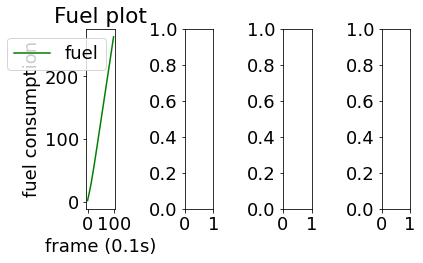

For state  tensor([-1.8379e-02,  1.4575e-01,  1.2224e-01, -6.1756e-01,  2.6235e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7768e-02,  1.4431e-01,  1.2139e-01, -6.1182e-01,  2.6237e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.8565e-02,  1.4327e-01,  1.2012e-01, -6.0659e-01,  2.6238e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7897e-02,  1.4205e-01,  1.1918e-01, -6.0091e-01,  2.6240e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.8284e-02,  1.4100e-01,  1.1810e-01, -5.9574e-01,  2.6241e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7098e-02,  1.3955e-01,  1.1734e-01, -5.9037e-01,  2.6243e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7235e-02,  1.3822e-01,  1.1635e-01, -5.8547e-01,  2.6244e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6403e-02,  1.3681e-01,  1.1539e-01, -5.8037e-01,  2.6245e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6790e-02,  1.3558e-01,  1.1438e-01, -5.7531e-01,  

For state  tensor([-9.2394e-03,  7.9168e-02,  6.8848e-02, -3.4068e-01,  2.6309e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.8897e-03,  7.8569e-02,  6.8408e-02, -3.3764e-01,  2.6310e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-9.0077e-03,  7.7712e-02,  6.7621e-02, -3.3508e-01,  2.6311e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.6958e-03,  7.7134e-02,  6.7413e-02, -3.3190e-01,  2.6311e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.7037e-03,  7.6427e-02,  6.6464e-02, -3.2956e-01,  2.6312e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.5738e-03,  7.5683e-02,  6.6428e-02, -3.2602e-01,  2.6313e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.4225e-03,  7.5073e-02,  6.5170e-02, -3.2383e-01,  2.6314e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.3717e-03,  7.4059e-02,  6.4779e-02, -3.1970e-01,  2.6315e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.0321e-03,  7.3564e-02,  6.3294e-02, -3.1742e-01,  

For state  tensor([-4.8734e-03,  4.4356e-02,  3.8471e-02, -1.9136e-01,  2.6349e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.0642e-03,  4.4064e-02,  3.8178e-02, -1.8978e-01,  2.6349e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.8377e-03,  4.3705e-02,  3.7875e-02, -1.8825e-01,  2.6350e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.9655e-03,  4.3395e-02,  3.7584e-02, -1.8670e-01,  2.6350e+02],
       grad_fn=<MvBackward>) 0
[38] loss: 0.038
For state  tensor([-4.9655e-03,  4.3395e-02,  3.7584e-02, -1.8670e-01,  2.6350e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.6925e-03,  4.2966e-02,  3.7234e-02, -1.8521e-01,  2.6351e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.8238e-03,  4.2625e-02,  3.6986e-02, -1.8362e-01,  2.6351e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.5770e-03,  4.2230e-02,  3.6614e-02, -1.8221e-01,  2.6351e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-4.7369e-03,  4.1902e-02,  3.6375e-0

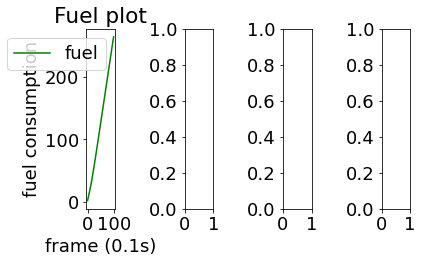

For state  tensor([-2.6616e-03,  2.5803e-02,  2.2529e-02, -1.1227e-01,  2.6370e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5714e-03,  2.5700e-02,  2.2391e-02, -1.1125e-01,  2.6370e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.6536e-03,  2.5295e-02,  2.2152e-02, -1.1042e-01,  2.6371e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5613e-03,  2.5156e-02,  2.2036e-02, -1.0940e-01,  2.6371e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5919e-03,  2.4857e-02,  2.1812e-02, -1.0861e-01,  2.6371e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5053e-03,  2.4780e-02,  2.1700e-02, -1.0760e-01,  2.6371e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5471e-03,  2.4466e-02,  2.1455e-02, -1.0682e-01,  2.6372e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.4765e-03,  2.4324e-02,  2.1326e-02, -1.0583e-01,  2.6372e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-2.5095e-03,  2.4019e-02,  2.1100e-02, -1.0505e-01,  

For state  tensor([-1.7753e-03,  1.4174e-02,  1.2529e-02, -6.1643e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6775e-03,  1.4013e-02,  1.2454e-02, -6.1105e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7509e-03,  1.3938e-02,  1.2311e-02, -6.0624e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6703e-03,  1.3786e-02,  1.2231e-02, -6.0079e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.7256e-03,  1.3719e-02,  1.2077e-02, -5.9609e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6491e-03,  1.3552e-02,  1.2015e-02, -5.9052e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6936e-03,  1.3491e-02,  1.1887e-02, -5.8598e-02,  2.6384e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6298e-03,  1.3330e-02,  1.1811e-02, -5.8081e-02,  2.6385e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.6852e-03,  1.3273e-02,  1.1650e-02, -5.7625e-02,  

For state  tensor([-1.0287e-03,  7.5544e-03,  6.5823e-03, -3.3558e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0858e-03,  7.4114e-03,  6.5804e-03, -3.3288e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0444e-03,  7.3833e-03,  6.5469e-03, -3.3042e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0407e-03,  7.3241e-03,  6.4912e-03, -3.2791e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0239e-03,  7.3162e-03,  6.4064e-03, -3.2514e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0952e-03,  7.1615e-03,  6.4482e-03, -3.2186e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0633e-03,  7.1353e-03,  6.4145e-03, -3.1970e-02,  2.6391e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0411e-03,  7.0838e-03,  6.3633e-03, -3.1721e-02,  2.6392e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.0492e-03,  7.0302e-03,  6.3018e-03, -3.1468e-02,  

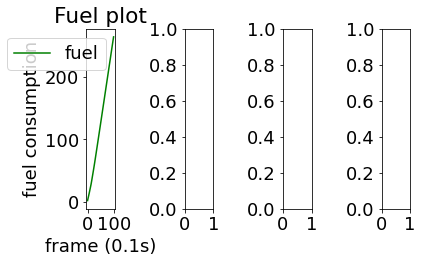

For state  tensor([ 5.8418e-04,  4.1872e-03,  2.8391e-03, -2.0630e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 5.9446e-04,  4.1606e-03,  2.8141e-03, -2.0456e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 5.5489e-04,  4.1228e-03,  2.7575e-03, -2.0293e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 5.5607e-04,  4.0771e-03,  2.7018e-03, -2.0099e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.5723e-04,  4.0228e-03,  2.8867e-03, -1.9873e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.5675e-04,  4.0163e-03,  2.8606e-03, -1.9780e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.7156e-04,  3.9905e-03,  2.4533e-03, -1.9617e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.2451e-04,  3.8922e-03,  1.8933e-03, -1.9122e-02,  2.6395e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.4991e-04,  3.8136e-03,  1.6564e-03, -1.8788e-02,  

For state  tensor([ 8.2922e-05,  1.8646e-03,  2.4397e-04, -1.0768e-02,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 8.5818e-05,  1.8355e-03,  1.9649e-04, -1.0690e-02,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.6363e-05,  1.7789e-03,  7.6684e-05, -1.0533e-02,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.9734e-05,  1.7012e-03, -1.1222e-04, -1.0322e-02,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.8375e-05,  1.5746e-03, -4.3190e-04, -9.9812e-03,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 9.5804e-05,  1.4119e-03, -8.2495e-04, -9.5394e-03,  2.6397e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.4191e-05,  1.2740e-03, -1.1327e-03, -9.1699e-03,  2.6398e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 8.3501e-05,  1.1775e-03, -1.3706e-03, -8.8570e-03,  2.6398e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.1865e-05,  1.0746e-03, -1.5495e-03, -8.5524e-03,  

For state  tensor([-1.3733e-04,  3.8368e-04, -1.1250e-03, -4.7606e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.4444e-04,  3.8165e-04, -1.0959e-03, -4.7212e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.5212e-04,  3.8499e-04, -1.0962e-03, -4.6940e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
[58] loss: 0.000
For state  tensor([-1.5212e-04,  3.8499e-04, -1.0962e-03, -4.6940e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.4716e-04,  3.8230e-04, -1.0731e-03, -4.6482e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.4786e-04,  3.8230e-04, -1.0697e-03, -4.6165e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.1848e-04,  3.8427e-04, -1.0504e-03, -4.5761e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.2365e-04,  3.8350e-04, -1.0437e-03, -4.5434e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-1.1886e-04,  3.8248e-04, -1.0228e-0

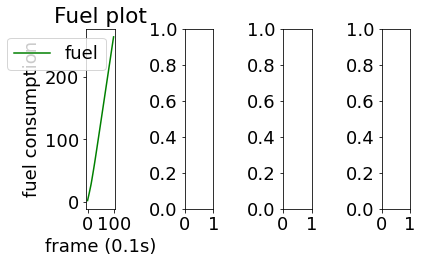

For state  tensor([-8.9599e-06,  2.2304e-04, -5.7380e-04, -2.4036e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.8863e-06,  2.2358e-04, -5.5133e-04, -2.3783e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.8164e-06,  2.2113e-04, -5.5547e-04, -2.3657e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-8.4715e-07,  2.1756e-04, -5.6090e-04, -2.3394e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-9.3406e-06,  2.1505e-04, -5.6709e-04, -2.3129e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.3856e-07,  2.1166e-04, -5.5527e-04, -2.2846e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-9.7579e-06,  2.0880e-04, -5.7027e-04, -2.2718e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.9251e-05,  1.8746e-04, -5.8186e-04, -2.0882e-03,  2.6399e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.9723e-05,  1.8728e-04, -5.6822e-04, -2.0643e-03,  

For state  tensor([-6.2917e-05,  1.0294e-04, -5.1677e-04, -1.2846e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-6.2917e-05,  1.0294e-04, -5.1677e-04, -1.2846e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
[67] loss: 0.000
For state  tensor([-6.2917e-05,  1.0294e-04, -5.1677e-04, -1.2846e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-6.3640e-05,  1.0270e-04, -5.0655e-04, -1.2798e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.9315e-05,  1.0139e-04, -5.1012e-04, -1.2784e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-5.9315e-05,  1.0139e-04, -5.1012e-04, -1.2784e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
[68] loss: 0.000
For state  tensor([-5.9315e-05,  1.0139e-04, -5.1012e-04, -1.2784e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-6.3998e-05,  1.0073e-04, -5.0445e-04, -1.2754e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.3691e-05,  9.840

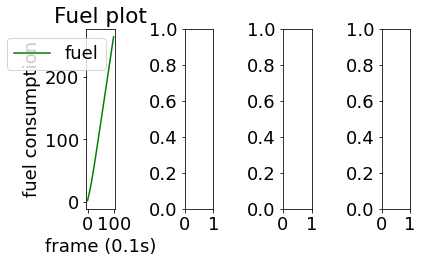

For state  tensor([-6.7746e-05,  9.0957e-05, -5.1082e-04, -1.2436e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-6.4184e-05,  9.0718e-05, -5.0543e-04, -1.2411e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.0564e-05,  8.9347e-05, -4.9868e-04, -1.2360e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-6.7758e-05,  8.8334e-05, -4.9649e-04, -1.2347e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.4190e-05,  8.6904e-05, -5.0158e-04, -1.2324e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.4190e-05,  8.6904e-05, -5.0158e-04, -1.2324e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
[72] loss: 0.000
For state  tensor([-7.4190e-05,  8.6904e-05, -5.0158e-04, -1.2324e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.5969e-05,  8.6427e-05, -4.9832e-04, -1.2296e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-7.0539e-05,  8.5652e-05, -4.9222e-0

For state  tensor([-2.8845e-04,  7.9274e-06, -4.9865e-04, -1.1106e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
[78] loss: 0.000
For state  tensor([-2.8845e-04,  7.9274e-06, -4.9865e-04, -1.1106e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.0020e-04,  5.1856e-06, -5.0590e-04, -1.1097e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.0755e-04,  3.6359e-06, -5.0653e-04, -1.1077e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.0755e-04,  3.6359e-06, -5.0653e-04, -1.1077e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
[79] loss: 0.000
For state  tensor([-3.0755e-04,  3.6359e-06, -5.0653e-04, -1.1077e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.1256e-04,  2.3246e-06, -5.1086e-04, -1.1067e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.1271e-04,  1.1921e-06, -5.1346e-04, -1.1053e-03,  2.6400e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([-3.1271e-04,  1.192

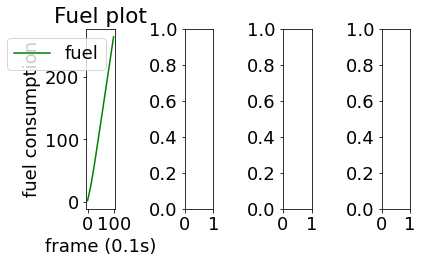

In [62]:
      # Now it's time to run the code!
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 20  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(81)  # solve the optimization problem
 

In [ ]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 20  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(81)  # solve the optimization problem

Sir formulation

In [37]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [38]:

# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [39]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [40]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential( #sequwential ntwork with
            nn.Linear(dim_input, dim_hidden), #linear
            nn.Tanh(), #nonlinear hyberbolic tangent function
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [41]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [42]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD(stochastic gradient descent) and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.02)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[1] loss: 1.412


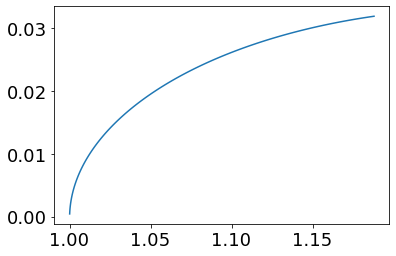

[2] loss: 0.478


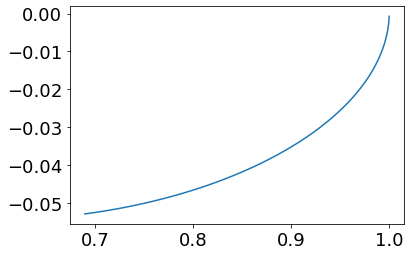

[3] loss: 0.175


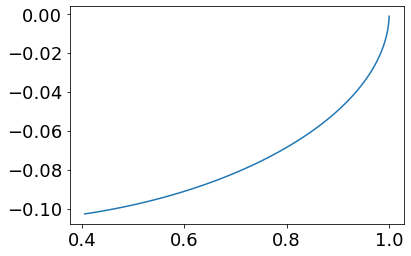

[4] loss: 0.080


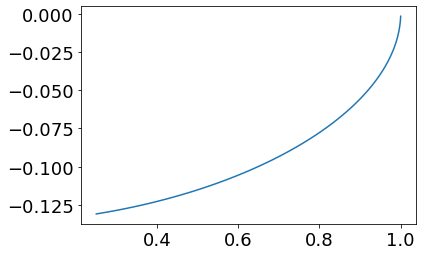

[5] loss: 0.049


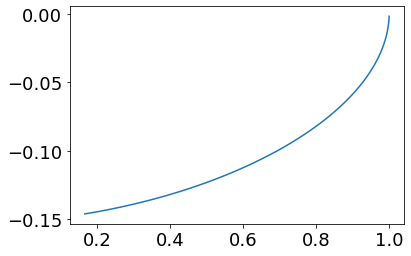

[6] loss: 0.038


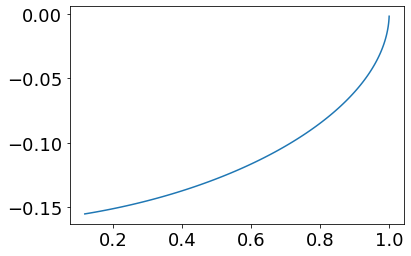

[7] loss: 0.033


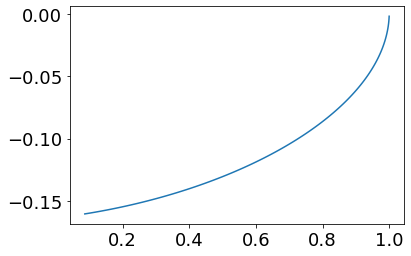

[8] loss: 0.031


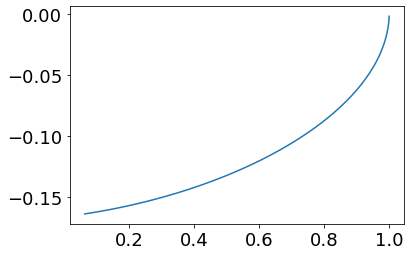

[9] loss: 0.030


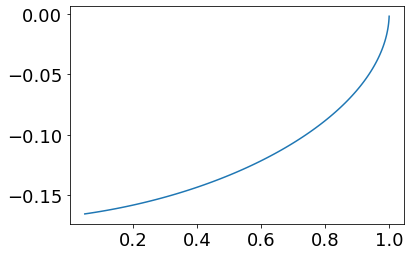

[10] loss: 0.029


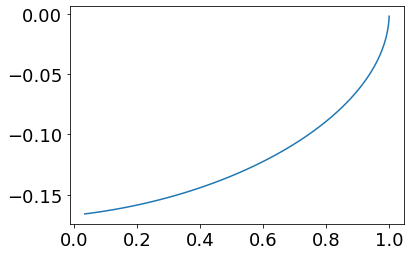

[11] loss: 0.028


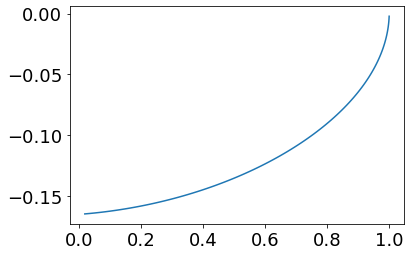

[12] loss: 0.026


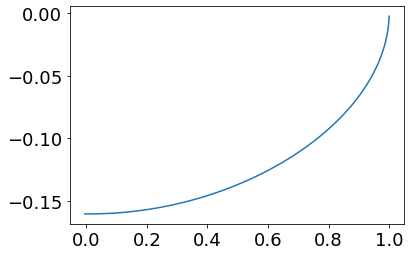

[13] loss: 0.004


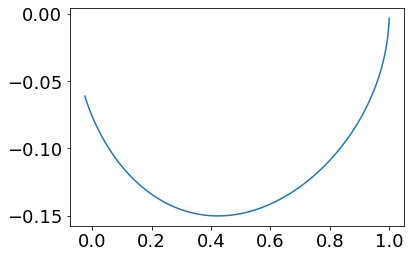

[14] loss: 0.002


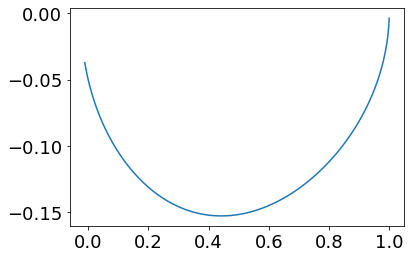

[15] loss: 0.001


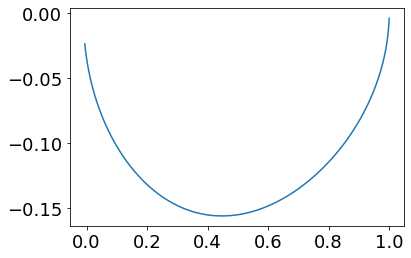

[16] loss: 0.000


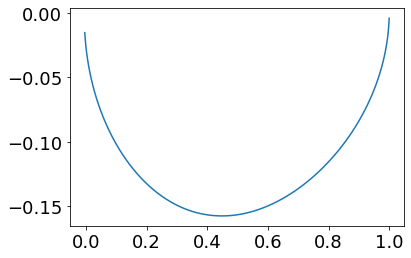

[17] loss: 0.000


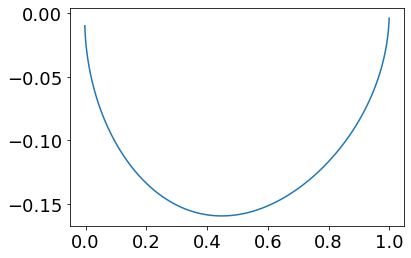

[18] loss: 0.000


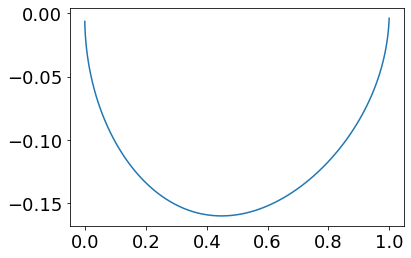

[19] loss: 0.000


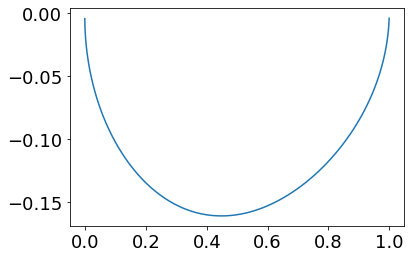

[20] loss: 0.000


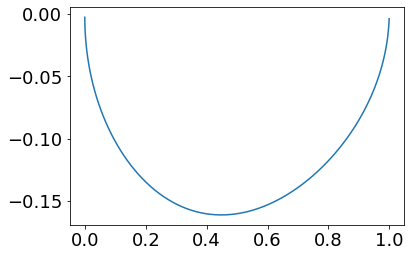

[21] loss: 0.000


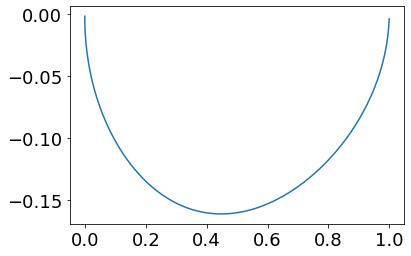

[22] loss: 0.000


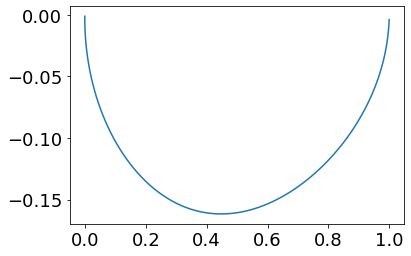

[23] loss: 0.000


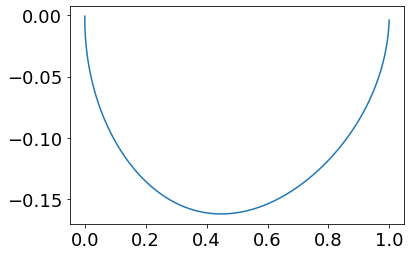

[24] loss: 0.000


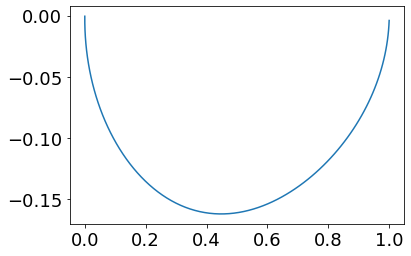

[25] loss: 0.000


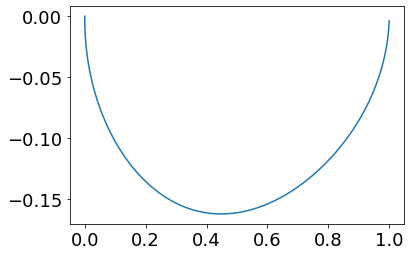

[26] loss: 0.000


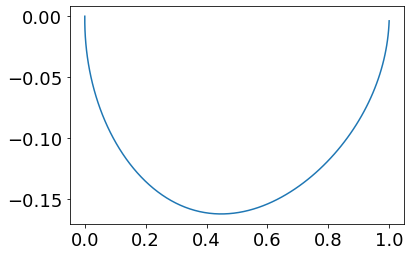

[27] loss: 0.000


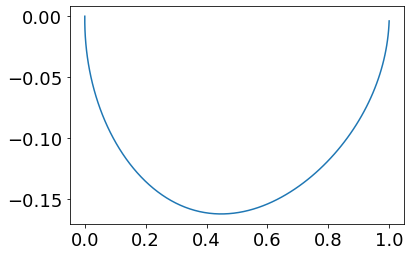

[28] loss: 0.000


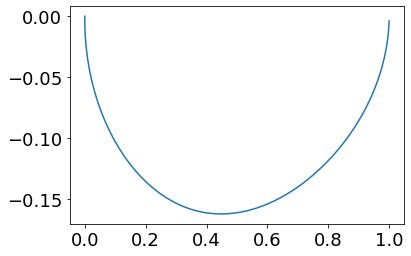

[29] loss: 0.000


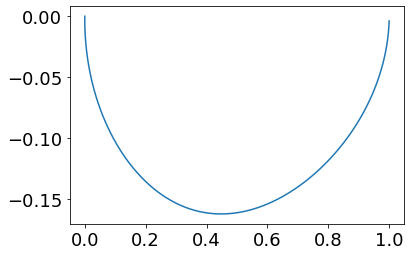

[30] loss: 0.000


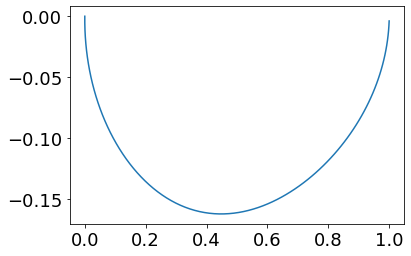

[31] loss: 0.000


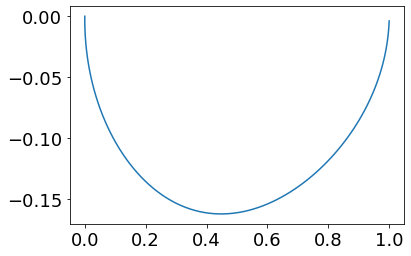

[32] loss: 0.000


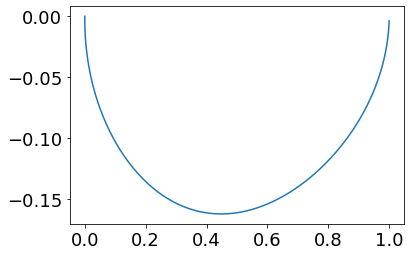

[33] loss: 0.000


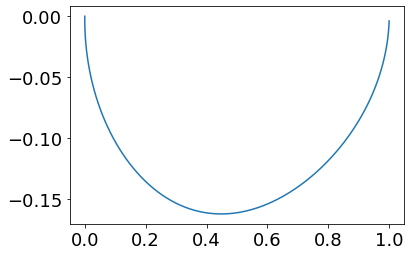

[34] loss: 0.000


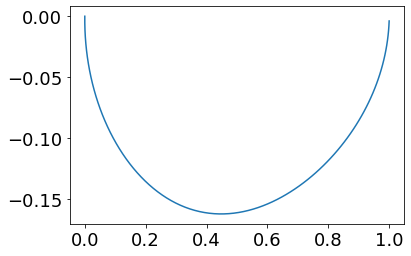

[35] loss: 0.000


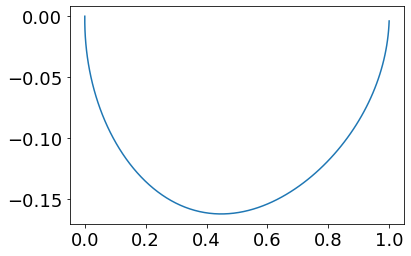

[36] loss: 0.000


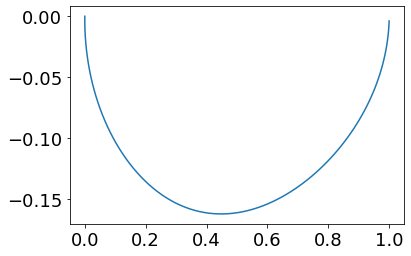

[37] loss: 0.000


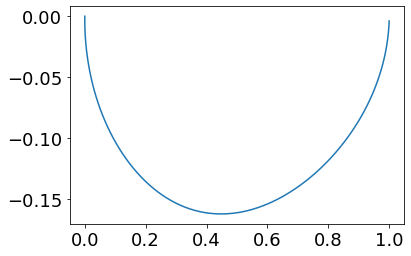

[38] loss: 0.000


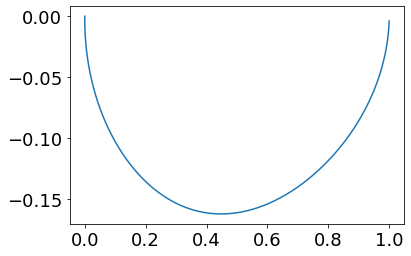

[39] loss: 0.000


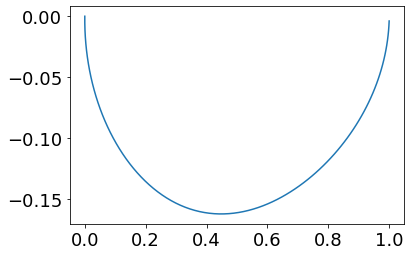

[40] loss: 0.000


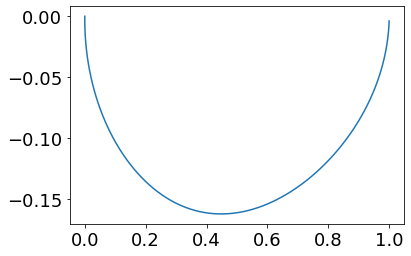

In [43]:

# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem


second try

In [ ]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)